# Homework 2

## Introduction

### Important dates

* Homework release: Thursday, 7th November 2019
* **Homework due: Wednesday, 20th November 2019 (23:59 hours, 11:59 PM)**
* **Peer review due: Wednesday, 27th November 2019 (23:59 hours, 11:59 PM)**
* Grading release: Monday, 9th December 2019

**Some rules:**
* You are allowed to use any built-in Python library that comes with Anaconda. You should make heavy use of `sklearn`, which will save you from (re)implementing any of the classical machine learning algorithms yourself. If you want to use an external library, you have to justify your choice.
* Make sure you use the data folder provided in the repository in read-only mode.
* Be sure to provide textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice.
* Back up any hypotheses and claims with data, since this is an important aspect of the course.
* Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a single notebook (plus the data files necessary) in the master branch. If there are multiple notebooks present, we will not grade anything.
* Also, be sure to hand in a fully-run and evaluated notebook. We will not run your notebook for you, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.
* **Important Note:** Owing to the scale of the datasets some tasks might take longer to finish, and hence, it is *recommended* that you start working on this homework as early as possible.

# Task A: Applied ML and Reading the Stats

## Description

You have been appointed as the manager/head-coach of Lausanne's men's football team [FC Lausanne-Sport](https://en.wikipedia.org/wiki/FC_Lausanne-Sport), and as a first step towards improving the team you decide to hire a new player. One way to assess the quality of a player would be to watch the games in which he participates. Since there are 22 players on the field, he will typically only have the ball for around 5-10 minutes per game. In addition, the ADA homework takes up all your free time, and hence, you need a more efficient and elegant solution.

You hypothesize that perhaps looking at the *physical capabilities* of the candidates such as *'running'* and *'jumping'* might be a good enough proxy for their skill as a football player. Thus, you come up with the idea of letting candidate players do just a couple of exercises such as *'100m sprint'* and *'high jump'*, and decide on one of the candidates based on his performance in these exercises. Because you are an aspiring data scientist, you want to use machine learning to optimize the player selection.

You come across a dataset of players from the football video game [FIFA 19](https://www.ea.com/games/fifa/fifa-19), which contains hand-annotated data about thousands of real-world football players, in particular about their skills in different domains.
Each row of the dataset corresponds to a player (you might recognize some of them). It contains information such as the player's nationality and their market value. However, the attributes that we are interested in are the skills of the players in various footballing aspects such as *'agility'*, *'dribbling'*, or *'heading accuracy'*. Apart from one attribute (see **A2.1.**), all of them are *non-negative* values in different bounded ranges, where a *higher value* corresponds to the *player being better* in that skill.

In [15]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import resample

%matplotlib inline

### A1. Getting a sense of the data

#### A1.1.
Load the data present at `data/fifa19_players.csv` into a Pandas DataFrame.

In [2]:
# load data to a dataframe named players
players = pd.read_csv("data/fifa19_players.csv", index_col=0)

# remove redundant column, Unnamed:0.1
players = players.rename(columns={"Unnamed: 0.1": "Unnamed: 0"})

#### A1.2.
The column *'Overall'* contains a score representing the overall performance of a football player. Before you start, you want to make sure that there is enough diversity in the dataset to draw meaningful conclusions (e.g. it shouldn't be the case that all players come roughly from the same skill class).
* First, think about what kind of distribution you would expect for the overall scores.
* Moving ahead, plot a histogram of the scores with *30 equal-width bins* and analyze the plot. Is this the distribution that you had expected?

> #### ***Explanation***
- Before plotting the histogram of overall performance, we would guess that the distribution for the overall scores would follow a **normal distribution**, which is the most common and useful distribution shown in many applications.

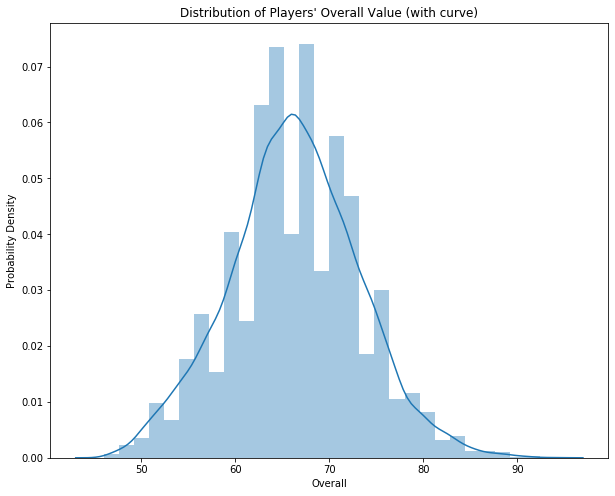

In [3]:
# plot the distribution of players' overall value with distribution curve
plt.figure(figsize=(10, 8))
sns.distplot(players.Overall, bins=30)
plt.xlabel("Overall")
plt.ylabel("Probability Density")
plt.title("Distribution of Players' Overall Value (with curve)")
plt.show()

> #### ***Explanation***
- From the plot above, the distribution approximately follows **bell-shaped** distribution.
- However, there are big **differences between neighboring bins**, making it not look exactly like normal distribution as we expected.

#### A1.3.
If you observe differences from what you expected in **A1.2.**, they might be due to a misrepresentation by the plot. Carefully study the actual values in the *'Overall'* column and **fix** the histogram accordingly! Redo the plot of step A1.2., and briefly state your observations.

In [4]:
# check the unique values in the column Overall
players['Overall'].unique()

array([94, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77,
       76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60,
       59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46])

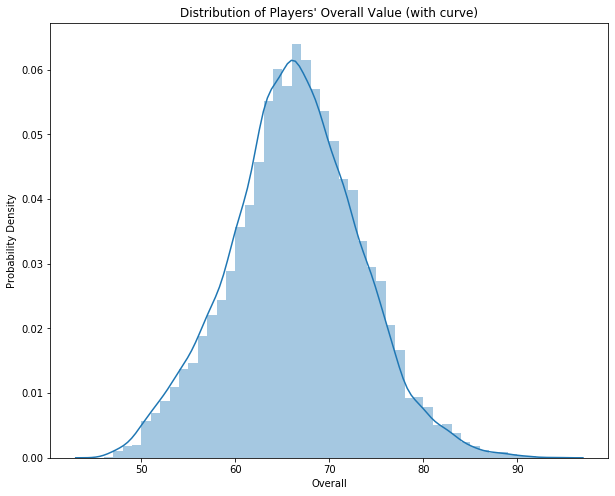

In [5]:
# change the number of bins and plot the histogram
plt.figure(figsize=(10, 8))
sns.distplot(players.Overall, bins=len(players.Overall.unique()))
plt.xlabel("Overall")
plt.ylabel("Probability Density")
plt.title("Distribution of Players' Overall Value (with curve)")
plt.show()

> #### ***Explanation***
- After our investigation, we observed that the value in the column 'Overall' simply ranges **from 46 to 94**.
- As a result, we changed the number of bins of the histogram to the **number of unique values** inside the column Overall. Each bin represents probability density of one unique value in the column.

### A2. Preprocessing

The features that you will use for the remainder of the tasks are the following; you can safely discard the rest of the columns.

In [6]:
skills = ['Overall', 'Weak Foot', 'Skill Moves', 'Work Rate', 'Crossing',
          'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
          'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
          'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
          'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
          'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
          'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
          'GKKicking', 'GKPositioning', 'GKReflexes']

In [7]:
# keep those columns in the list, skills
players = players[skills]

#### A2.1.
Since your final goal will be to train a *linear machine learning model*, all of the features you use need to be *numerical*. 'Work Rate' refers to how much effort a player puts into his play when attacking and defending, respectively, but it is non-numeric and non-atomic. Transform the feature into _two_ numerical features.

In [8]:
# check the value in the column 'Work Rate'
players['Work Rate'].head()

0    Medium/ Medium
1         High/ Low
2      High/ Medium
3    Medium/ Medium
4        High/ High
Name: Work Rate, dtype: object

In [9]:
# split the feature into two separate features, 'Attacking Work Rate' and 'Defending Work Rate'
temp = players["Work Rate"].str.split("/ ", n=1, expand=True)
players["Attacking Work Rate"] = temp[0]
players["Defending Work Rate"] = temp[1]

# transform these two features into two numerical features 
# with transformation described in 'rate_transform'
rate_transform = {"Low": 1, "Medium": 2, "High": 3}
players["Attacking Work Rate"] = players["Attacking Work Rate"].map(
    rate_transform, na_action="ignore"
)
players["Defending Work Rate"] = players["Defending Work Rate"].map(
    rate_transform, na_action="ignore"
)


#### A2.2.
As it is true for any real-world dataset out there, you might encounter *missing values*. There are numerous ways to *impute* them (fill them up) by looking at records for which these values are not missing.
* Use a *simple aggregation* of the records for which the values are present (not missing) to fill in the missing values.
* Briefly *justify* the choice of your *aggregation scheme*.

In [10]:
# identify which column has missing values
players.columns[players.isnull().sum() != 0]

Index(['SprintSpeed'], dtype='object')

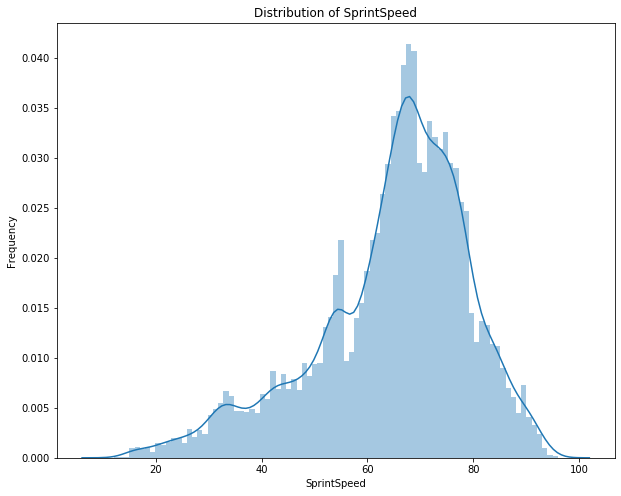

In [11]:
# check the non-missing value in the column, 'SprintSpeed'
players_SprintSpeed_non_missing = players.SprintSpeed[players.SprintSpeed.notnull()]

# check its distribution
plt.figure(figsize=(10, 8))
sns.distplot(
    players_SprintSpeed_non_missing, bins=len(players_SprintSpeed_non_missing.unique())
)
plt.xlabel("SprintSpeed")
plt.ylabel("Frequency")
plt.title("Distribution of SprintSpeed")
plt.show()

In [12]:
# use median to replace the missing value
median = players_SprintSpeed_non_missing.median()
players.SprintSpeed.fillna(median, inplace = True)

> #### ***Explanation***
- According to our observation, we found out that only the column **'SprintSpeed' contains 6 missing values**.
- Because the distribution of the column is **skewed**, it is better to use robust statistics to substitute the missing values.
- Thus, we decided to use the **median** to replace the missing values in that column.


## A3. Building a regression model

By letting them perform exercises, you have gathered data about the following athletic skills (except for the *overall football performance*) of your candidate players:

In [13]:
athletic_skills = ['Overall', 'Acceleration', 'SprintSpeed',
                   'Agility', 'Reactions', 'Balance',
                   'Jumping', 'Stamina', 'Strength']

To decide which player to hire, you need to know how these skills transfer to football performance.

To predict the football performance of a player, you want to build a linear model with an additional regularization term to prevent overfitting. The specific model used in this exercise is L2-regularized linear regression, aka "Ridge Regression". It combines the least squares linear regression model that you know from the lecture with a penalty on the norm of the weight vector [1]. The function that Ridge Regression minimizes is

$$||y-Xw||_2^2 + \alpha ||w||_2^2,$$

where $y$ is a vector of overall ratings, $X$ is the matrix of data vectors with each *row* being the features of a football player, $w$ is the weight vector, and $\alpha$ is the (non-negative) regularization parameter.

[1] If there are enough model parameters, a powerful machine learning model will be able to "memorize" the value it is supposed to predict for some training examples. That means, it will perform well on those training examples, but will perform much worse on data that was not used for training. One way to counter this is to penalize large weight values. This can be thought of as reducing the complexity of the model.

### A3.1.
Split the data randomly into a train (70%) and a test set (30%). Use 1 as the random seed.

In [14]:
# load data and their outputs
X = players[athletic_skills].drop(["Overall"], axis=1)
y = players["Overall"]

# split the data into training data and testing data
seed = 1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)

### A3.2.
Build a Ridge Regression model that predicts a player's overall football performance from the other feature in the list above (sklearn might be helpful here).

Ridge Regression has a regularization parameter $\alpha$. Optimize it in the range [0, 2000] via cross validation. Use as a metric the mean squared error. Plot the cross-validation error as a function of the regularization parameter and choose the best parameter for your final model.

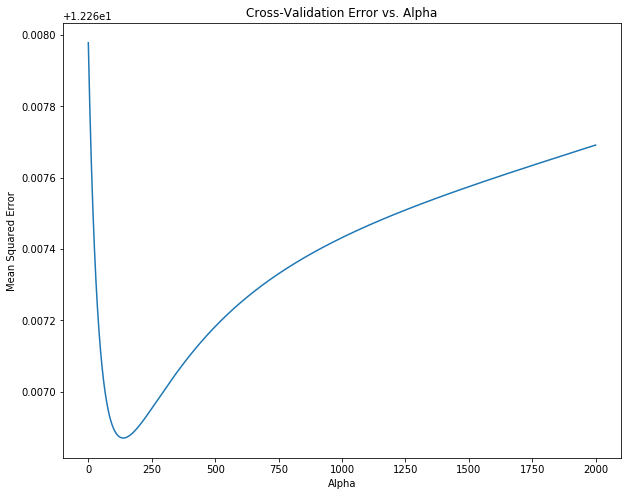

In [15]:
# create a range of possilbe tuning parameters, alpha
alphas = list(range(2001))
alphas_best = []

# build the ridge regression model for each alpha and store the cross-validation error
cross_val_errors = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    predict = cross_val_predict(ridge, X_train, y_train, cv=10)
    cross_val_errors.append(mean_squared_error(y_train, predict))

# plot the cross-validation error as a function of the regularization parameter
plt.figure(figsize=(10, 8))
plt.plot(alphas, cross_val_errors)
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.title("Cross-Validation Error vs. Alpha")
plt.show()

In [16]:
# choose the best alpha for our model
index_min_error = cross_val_errors.index(min(cross_val_errors))
alpha_best = alphas[index_min_error]
print("best alpha:", alpha_best)

best alpha: 138


> #### ***Explanation***
- Here we could see that the best alpha for our ridge regression model is 138, which is so high that we speculate it would **suppress the weights** for all features to be close to 0.

## A4. Feature importance

Hiring new players isn't the only job of a manager/head-coach; another important one is training players. While you are at it, you think, why not use the insights gained from the hiring process to also improve the training process of your entire team? Since a training session can only last a limited amount of time and there are several possible exercises to do, you want to know which athletic skill should your training process focus the most upon. Your idea is to use the *weights* of your regression model as a guidance: In your opinion, a *higher weight* for an athletic skill should mean that this skill is highly *predictive* of the football performance.

### A4.1.
* Print the weights. Why might it *not* be a good idea to use them as they are for gauging a skill's importance?
* How can you fix this?
* What has changed due to your fix?

*Hint: Some skills could get disadvantaged (carefully study the ranges of the corresponding features)! This can be prevented by another preprocessing step discussed in the lecture that takes care of differing ranges, after which you need to train the model again.*

In [17]:
# show the weights of each feature
ridge.fit(X_train, y_train)
df_features = pd.DataFrame({"features": athletic_skills[1:], "weights": ridge.coef_})
feature_weights = (
    df_features.sort_values(by=["weights"], ascending=False)
    .reset_index()
    .drop("index", axis=1)
)
display(feature_weights)

,features,weights
0,Reactions,0.604083
1,Strength,0.072934
2,Agility,0.048209
3,Jumping,0.039364
4,SprintSpeed,0.015756
5,Acceleration,0.003130
6,Stamina,-0.006994
7,Balance,-0.031917


In [18]:
# list a range of every feature
for f in range(len(athletic_skills[1:])):
    feature = athletic_skills[1:][f]
    print(
        "{0} ranges from {1} to {2}".format(
            feature, min(players[feature].values), max(players[feature].values)
        )
    )


Acceleration ranges from 12.0 to 97.0
SprintSpeed ranges from 12.0 to 96.0
Agility ranges from 14.0 to 96.0
Reactions ranges from 21.0 to 96.0
Balance ranges from 16.0 to 96.0
Jumping ranges from 0.15 to 0.95
Stamina ranges from 12.0 to 96.0
Strength ranges from 17.0 to 97.0


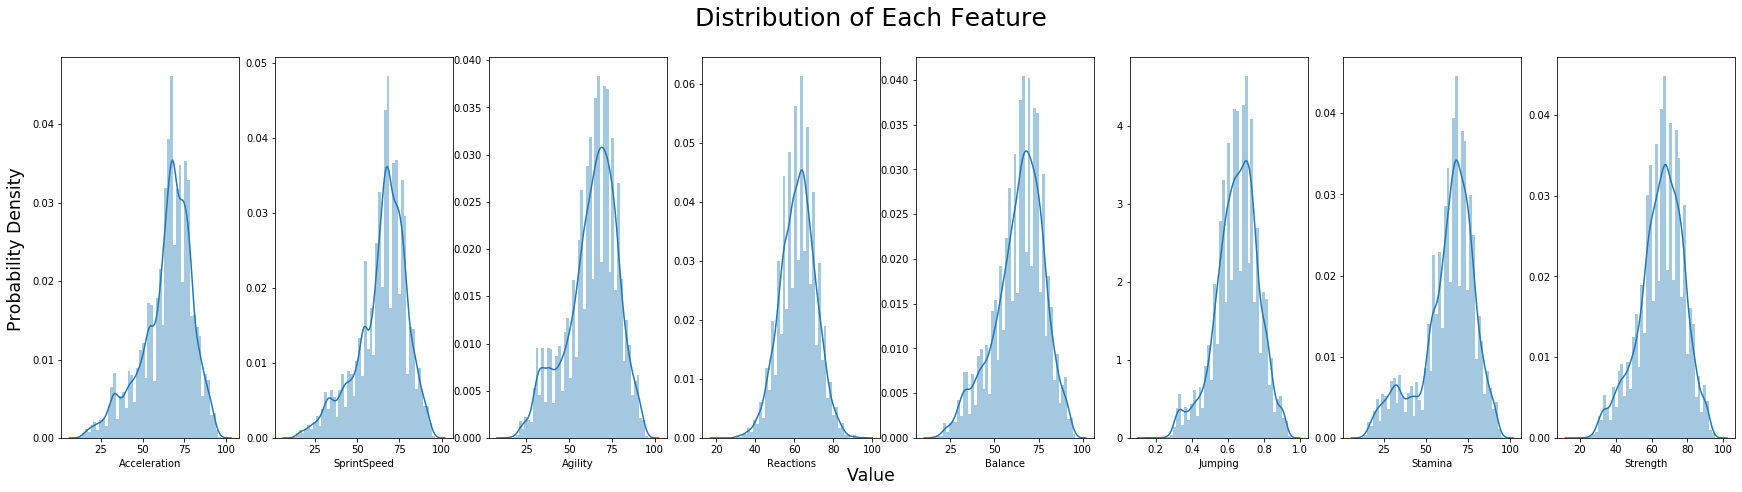

In [19]:
# plot the distribution of features
fig, axes = plt.subplots(1, 8, figsize=(30, 7))
for i, ax in zip(range(8), axes.flat):
    sns.distplot(players[athletic_skills[1:]].iloc[:, i], ax=ax)
fig.suptitle("Distribution of Each Feature", fontsize=25)
fig.text(0.5, 0.04, "Value", ha="center", fontsize="xx-large")
fig.text(
    0.1,
    0.5,
    "Probability Density",
    va="center",
    rotation="vertical",
    fontsize="xx-large",
)
plt.show()

> #### ***Explanation***
- Based on our last model, the hyperparameter **alpha is pretty large**.
- As a result, we observed that most **weights are small**.
- In addition, we found that the range of the feature **Jumping is different** from the rest.
- Therefore, we need to normalize the ranges of all features to make them to be within **[0, 1]**. 
- Since the distribution of the features is **skewed**, we decided to use min-max scaling for normalization.

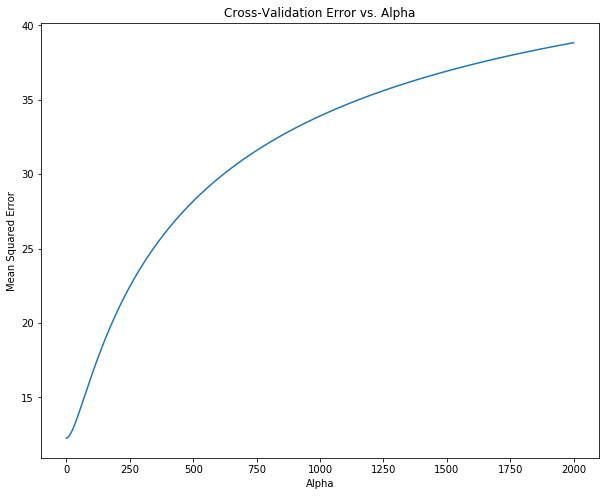

In [20]:
# standardization of each feature
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# retrain our model
cross_val_errors = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    predict = cross_val_predict(ridge, X_train_scaled, y_train, cv=10)
    cross_val_errors.append(mean_squared_error(y_train, predict))

# plot the cross-validation error as a function of the regularization parameter
plt.figure(figsize=(10, 8))
plt.plot(alphas, cross_val_errors)
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.title("Cross-Validation Error vs. Alpha")
plt.show()

,features,weights
0,Reactions,45.376898
1,Strength,5.176979
2,Agility,3.924423
3,SprintSpeed,1.318964
4,Jumping,0.472366
5,Acceleration,0.282633
6,Stamina,-0.640311
7,Balance,-2.648234


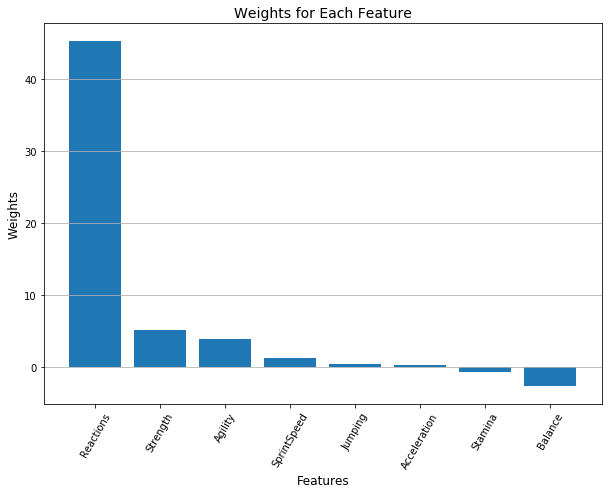

In [23]:
# pick the best alpha for our model
index_min_error = cross_val_errors.index(min(cross_val_errors))
alpha_best = alphas[index_min_error]
alphas_best.append(alpha_best)
ridge = Ridge(alpha=alpha_best)
ridge.fit(X_train_scaled, y_train)

# show the weights of each feature
df_features = pd.DataFrame({"features": athletic_skills[1:], "weights": ridge.coef_})
feature_weights = (
    df_features.sort_values(by=["weights"], ascending=False)
    .reset_index()
    .drop("index", axis=1)
)
display(feature_weights)

# plot the weights
plt.figure(figsize=(10, 7))
plt.bar(feature_weights.features, feature_weights.weights)
plt.grid(axis="y")
plt.xticks(rotation=60)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Weights", fontsize=12)
plt.title("Weights for Each Feature", fontsize=14)
plt.show()

> #### ***Explanation***
- This time after applying **min-max scaling**, the weights of the features become larger.
- From here, we can see that the feature **Reactions is the most important** predictor for overall performance.
- In addition, we also oberved that **SprintSpeed and Jumping switched** their relative importance after normalization.

### A4.2.
* After the *fix* in step A4.1., is everything fine now with the weights? Sort the weights in descending order. Do you observe anything unexpected with the lowest-ranked weights?
* Do you have an idea what could be the potential cause for this? (No need to analytically prove your hypothesis.)
* Come up with a better way to gauge the importance of a feature for the overall performance.

In [25]:
# sort the weights in descending order
df_features = pd.DataFrame({"features": athletic_skills[1:], "weights": ridge.coef_})
df_features.sort_values(by=["weights"], ascending=False).reset_index().drop(
    "index", axis=1
)

,features,weights
0,Reactions,45.376898
1,Strength,5.176979
2,Agility,3.924423
3,SprintSpeed,1.318964
4,Jumping,0.472366
5,Acceleration,0.282633
6,Stamina,-0.640311
7,Balance,-2.648234


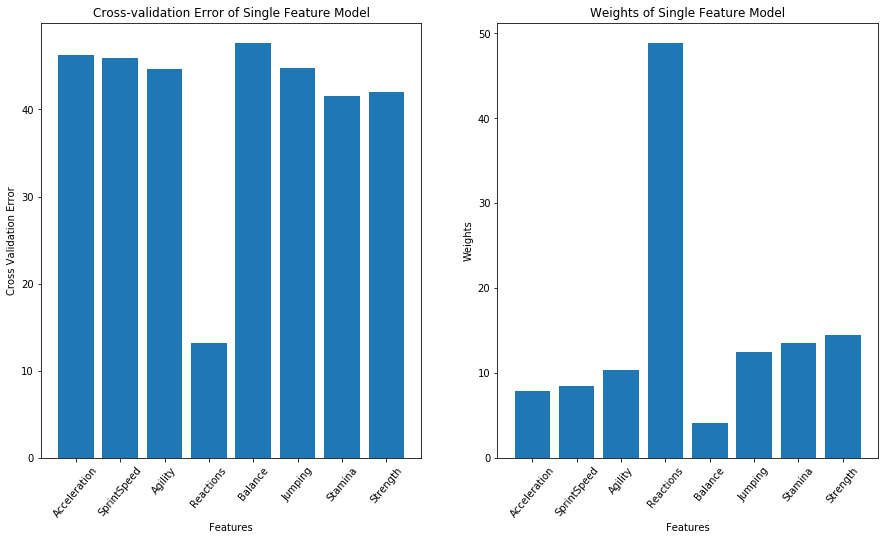

In [26]:
# fit a linear model on a single feature for each feature
# and evaluate the cross-validation error
cross_val_errors = []
single_fit_slopes = []
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
for column in X_train.columns:
    X_single_feature = pd.DataFrame(df_X_train_scaled[column])
    lm = LinearRegression()
    predict = cross_val_predict(lm, X_single_feature, y_train, cv=10)
    cross_val_errors.append(mean_squared_error(y_train.values, predict))
    lm.fit(X_single_feature, y_train)
    single_fit_slopes.append(lm.coef_[0])

# plot the cross-validation error and weights of one-feature model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.bar(X_train.columns, cross_val_errors)
ax2.bar(X_train.columns, single_fit_slopes)
ax1.set_xticklabels(X_train.columns, rotation=50)
ax2.set_xticklabels(X_train.columns, rotation=50)
ax1.set_xlabel("Features")
ax2.set_xlabel("Features")
ax1.set_ylabel("Cross Validation Error")
ax2.set_ylabel("Weights")
ax1.set_title("Cross-validation Error of Single Feature Model")
ax2.set_title("Weights of Single Feature Model")
plt.show()

> #### ***Explanation***
- After sorting the weights, we could see that two features, **Stamina and Balance, negatively contribute** to players' overall performance prediction, which seems contradictory to our imagination on their meaning.
- However, after fitting the linear model with **one feature alone**, we discovered that **every feature positively contributes** to predicting the overall perforamce.
- Therefore, we considered that several weights are negative after combining all the features into a model might result from **correlation** between features.
- To better assess one feature to overall football performance, we suggest using one feature each time to fit the model to see whether it has positive contribution for overall performance prediction (**offline feature selection**).

## A5. Model Improvements

During the ongoing recruiting process, it turns out that attending all the ADA lectures and tutorials has paid off: Solving the ADA homework went like a charm and you are already done with it. Now you wonder whether it is worth going to some football games of the candidates to assess their football-related skills explicitly, and include these skills in training your ML model.

### A5.1. Improving the model
Train a second model, this time also including as features the football-related skills from the list in the step **A2**. Again use cross validation to compute the best hyperparameter in the range [0,2000].

In [28]:
# train the second model
# load data and their outputs
X_2 = players.drop(["Overall", "Work Rate"], axis=1)
y_2 = players["Overall"]

# split the data into training data and testing data
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(
    X_2, y_2, test_size=0.3, random_state=seed
)

# apply min-max scaling for normalization
X_2_train_scaled = scaler.fit_transform(X_2_train)

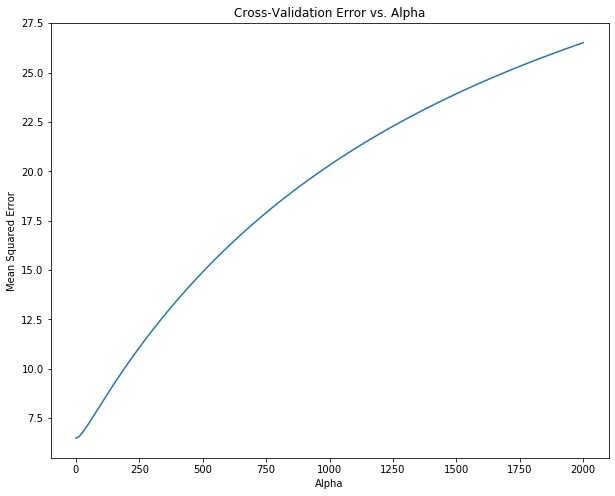

In [29]:
# build the ridge regression model for each alpha and store the cross-validation error
cross_val_errors = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    predict = cross_val_predict(ridge, X_2_train_scaled, y_2_train, cv=10)
    cross_val_errors.append(mean_squared_error(y_2_train, predict))

# plot the cross-validation error as a function of the regularization parameter
plt.figure(figsize=(10, 8))
plt.plot(alphas, cross_val_errors)
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.title("Cross-Validation Error vs. Alpha")
plt.show()

,features,weights
0,Reactions,21.006944
1,BallControl,11.438138
2,Composure,9.650559
3,HeadingAccuracy,8.580714
4,GKHandling,7.360135
5,GKReflexes,7.049650
6,GKDiving,7.007046
7,ShortPassing,6.723857
8,Skill Moves,6.106307
9,GKPositioning,5.754436


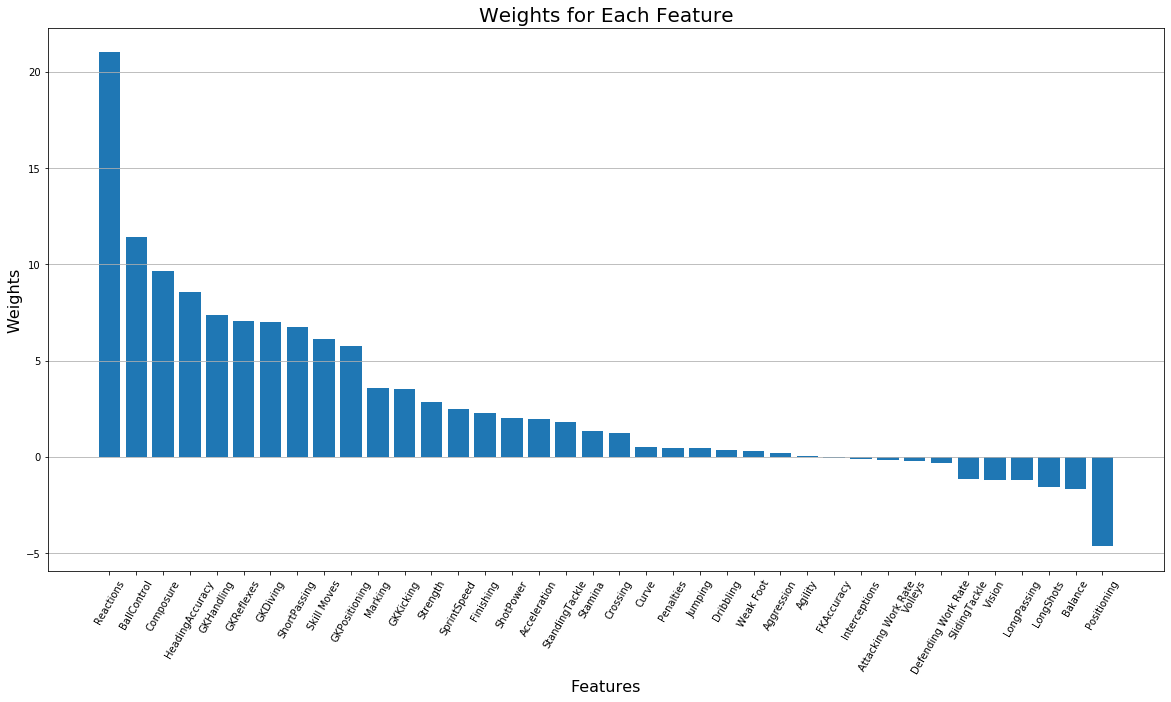

In [30]:
# choose the best alpha for our model
index_min_error = cross_val_errors.index(min(cross_val_errors))
alpha_best = alphas[index_min_error]
alphas_best.append(alpha_best)
ridge = Ridge(alpha=alpha_best)
ridge.fit(X_2_train_scaled, y_2_train)

# show the weights of each feature
df_features = pd.DataFrame({"features": X_2_train.columns, "weights": ridge.coef_})
feature_weights = (
    df_features.sort_values(by=["weights"], ascending=False)
    .reset_index()
    .drop("index", axis=1)
)
display(feature_weights)

# plot the weights for all features
plt.figure(figsize=(20, 10))
plt.bar(feature_weights.features, feature_weights.weights)
plt.grid(axis="y")
plt.xticks(rotation=60)
plt.xlabel("Features", fontsize=16)
plt.ylabel("Weights", fontsize=16)
plt.title("Weights for Each Feature", fontsize=20)
plt.show()

### A5.2. Assessing the improvement
Compute *bootstrap confidence intervals* for the mean squared error that the two models (trained in the steps **A3** and **A5.1**) make. Retrain both models *1000 times*, each time with a different random train/test split, and compute the respective mean squared errors.   
*Note: Use the 'optimal regularization parameters' already found via cross validation in steps **A3** and **A5.1**.*

* Find the *two-sided 95% confidence intervals* via bootstrap resampling and plot the mean error together with the confidence interval in a bar plot.
* What can you say about the properties of the models based on the confidence intervals?
* Do you have sufficient evidence to claim that one model is clearly better than the other? Clearly explain your observations!

In [31]:
# contruct the function executing bootstrap
def bootstrap(X, y, alpha, n_iteration=1000):
    errors = []
    for i in range(n_iteration):
        # prepare training and testing set
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=i + 1
        )
        ind_resampled = resample(np.arange(len(X_train)), random_state=i + 1)
        X_train_resampled, y_train_resampled = (
            X_train[ind_resampled],
            y_train[ind_resampled],
        )
        # compute the model's mean squared error
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_resampled, y_train_resampled)
        predict = ridge.predict(X_test)
        errors.append(mean_squared_error(y_test, predict))
    return errors

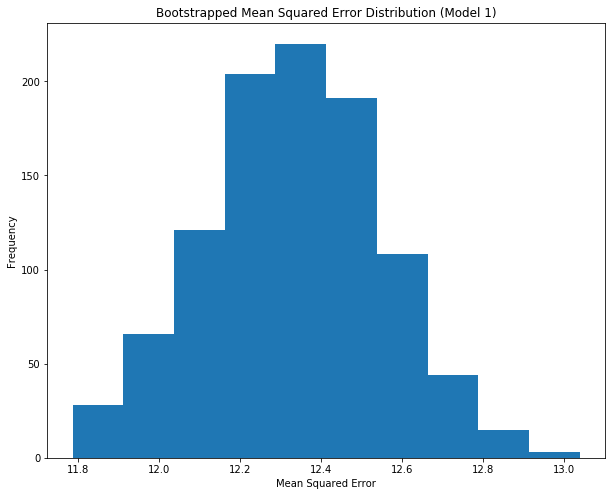

In [32]:
# run bootstrap for the first model
X_scaled = scaler.fit_transform(X)
errors_1 = bootstrap(X_scaled, y.values, alphas_best[0])

# check the histogram of mean squared errors of the first model
plt.figure(figsize=(10, 8))
plt.hist(errors_1)
plt.xlabel("Mean Squared Error")
plt.ylabel("Frequency")
plt.title("Bootstrapped Mean Squared Error Distribution (Model 1)")
plt.show()

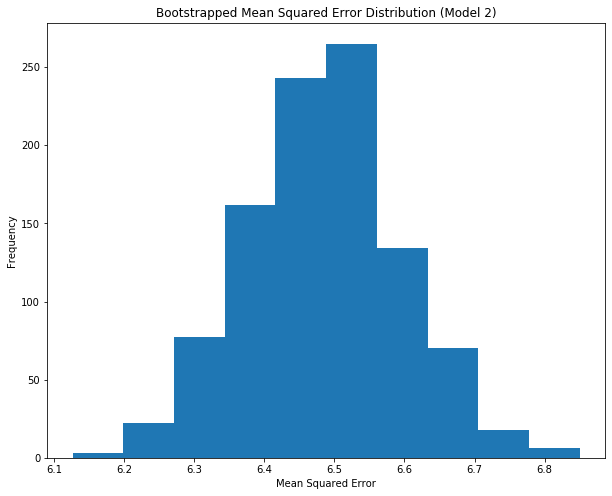

In [33]:
# run bootstrap for the second model
X_2_scaled = scaler.fit_transform(X_2)
errors_2 = bootstrap(X_2_scaled, y_2.values, alphas_best[1])

# check the histogram of mean squared errors of the second model
plt.figure(figsize=(10, 8))
plt.hist(errors_2)
plt.xlabel("Mean Squared Error")
plt.ylabel("Frequency")
plt.title("Bootstrapped Mean Squared Error Distribution (Model 2)")
plt.show()

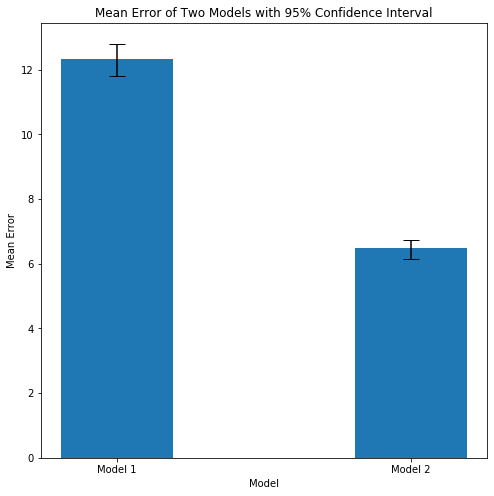

In [34]:
# find their respective means and standard deviation
mean_errors = [np.array(errors_1).mean(), np.array(errors_2).mean()]
percentile_0025_1 = np.percentile(errors_1, 0.025)
percentile_0975_1 = np.percentile(errors_1, 0.975)
percentile_0025_2 = np.percentile(errors_2, 0.025)
percentile_0975_2 = np.percentile(errors_2, 0.975)
errors_lower = [mean_errors[0] - percentile_0025_1, mean_errors[1] - percentile_0025_2]
errors_upper = [mean_errors[0] - percentile_0975_1, mean_errors[1] - percentile_0975_2]

# plot the bar plot for these 2 models
plt.figure(figsize=(8, 8))
bars = ["Model 1", "Model 2"]
pos = np.arange(len(mean_errors))
plt.bar(
    pos,
    mean_errors,
    yerr=[errors_lower, errors_upper],
    ecolor="black",
    capsize=8,
    width=0.38,
)
plt.xticks(pos, bars)
plt.xlabel("Model")
plt.ylabel("Mean Error")
plt.title("Mean Error of Two Models with 95% Confidence Interval")
plt.show()

> #### ***Explanation***
- Our main observation is that the second model has **much smaller mean error** compared to one of the first model.
- Here, we interpreted mean errors as **bias** of the models and length of confidence interval as the **variance** of models.
- Also, we noticed that **both the variances of two models are smaller than the bias difference**. 
- Given this, **we prefer the second model** because it has much lower bias.

# Task B: Scaling up

## Description

[Reddit](https://www.reddit.com/) aka *'the front page of the internet'* is a network of over a million *communities* aka *'subreddits'*, each of which covers a different topic based on people's interests. In other words, it is a *massive* collection of forums (corresponding to the aforementioned communities), where people can share content specific to a given topic or comment on other people’s posts.   

You are reddit's community manager and want to *appoint new moderators*. Because moderating a specific subreddit isn't a full-time job, you want the chosen moderators to moderate multiple subreddits at the same time. To make this choice effective, the moderators shouldn't have to spend too much time getting to know the community and the prevalent communication style, so it makes sense to let moderators moderate subreddits that are similar in communication style and language. At the same time, it also makes sense to let them moderate subreddits that are similar with respect to the participating users, because this allows moderators to track the behavior of individual users over multiple subreddits. For example, some users might only post offensive content once a month on a given subreddit, and therefore fly under the radar with someone moderating only that subreddit. However, considering all the subreddits these users post to, they might post something offensive every day but on different subreddits. Thus, a moderator in charge of all these subreddits would be able to ban such users much more effectively. In the light of the above description, your task is to find out ways to choose moderators considering both the textual content and the users of a subreddit.

### Dataset:
The dataset provided to you includes all the posts of the 15 largest subreddits written as of May 2015.

Reddit posts (provided to you via a [google drive folder](https://drive.google.com/a/epfl.ch/file/d/19SVHKbUTUPtC9HMmADJcAAIY1Xjq6WFv/view?usp=sharing))
```
reddit_posts
 |-- id: id of the post 
 |-- author: user name of the author 
 |-- body: text of the message
 |-- subreddit: name of the subreddit
```

Reddit scores (provided to you via a [google drive folder](https://drive.google.com/a/epfl.ch/file/d/1vr4PolJzTXr6ODSe3ucib5EAyp3rjxec/view?usp=sharing))
```
reddit_scores
 |-- id: id of the post 
 |-- score: score computed as sum of UP/DOWN votes
```

*Note: Jaccard similarity between subreddits represented using either the set of top-1000 words or the set of users can be computed locally (on the driver), however, all the other tasks have to be implemented in Spark.*

## B1. Getting a sense of the data

Start a PySpark instance...

In [1]:
import pyspark
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
import pyspark.sql
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType

conf = (
    pyspark.SparkConf()
    .setMaster("local[*]")
    .setAll(
        [
            ("spark.executor.memory", "12g"),
            ("spark.driver.memory", "12g"),
            ("spark.driver.maxResultSize", "12G"),
        ]
    )
)
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

... and load the data in a Spark dataframe.

In [2]:
# load data to Spark dataframes
posts = spark.read.json("messages.json.gz")
scores = spark.read.json("score.json.gz")

### B1.1. Identify the most active subreddit

Print the list of subreddits along with the following information:
1. The total number of posts
2. The number of users with at least 1 message
3. The mean message length

*Note: Keep everything in one single dataframe and print the list sorted by number of posts in descending order.*

In [41]:
# check whether there is a row in body containing null value
posts.where(col("body").isNull()).show()

+------+----+---+---------+
|author|body| id|subreddit|
+------+----+---+---------+
+------+----+---+---------+



In [4]:
# compute the number of posts in each subreddit
num_posts = (
    posts.groupBy("subreddit")
    .agg(count("*").alias("posts_num"))
    .sort(desc("posts_num"))
)

In [5]:
# compute the number of users with at least 1 message in each subreddit
num_users_message = (
    posts.groupBy("subreddit")
    .agg(countDistinct("author").alias("users_num"))
    .sort(desc("users_num"))
)

In [6]:
# compute the message length for each post
posts_with_message_len = posts.withColumn("message_len", length("body"))

# compute mean message length in each subreddit
mean_message_length = (
    posts_with_message_len.groupBy("subreddit")
    .agg(avg("message_len").alias("mean_message_len"))
    .sort(desc("mean_message_len"))
)

In [7]:
# compute standard deviation of message length in each subreddit
std_message_length = (
    posts_with_message_len.groupBy("subreddit")
    .agg(stddev("message_len").alias("std_message_len"))
    .sort(desc("std_message_len"))
)

In [9]:
# merge 3 specified information into a Spark dataframe
active_subreddit = (num_posts.join(num_users_message, "subreddit")).join(
    mean_message_length, "subreddit"
)
active_subreddit.sort(desc('posts_num')).show()

+---------------+---------+---------+------------------+
|      subreddit|posts_num|users_num|  mean_message_len|
+---------------+---------+---------+------------------+
|leagueoflegends|  1151287|   119321|152.72280760574904|
|            nba|   704862|    45034|106.48656758344187|
|          funny|   691139|   224077|106.82283882113438|
|           pics|   564502|   205305| 114.9710045314277|
|            nfl|   534345|    41593|148.96989211090212|
|         videos|   511492|   157628|170.22702603364274|
|           news|   477658|    98736| 230.9491602778557|
| DestinyTheGame|   471160|    37008|165.41786866457255|
|         soccer|   455215|    41648|134.42224663071295|
|          DotA2|   445154|    41466|141.48906670500546|
|      worldnews|   439417|    99261|224.93754679495785|
|  AdviceAnimals|   411902|   115815| 159.2513801826648|
|         hockey|   389329|    25568| 95.37287230080472|
|GlobalOffensive|   382017|    46686| 147.2883981602913|
|         movies|   354601|    

### B1.2. Identify the largest subreddit

Print *two* different lists of subreddits: ordered by (1) the number of posts, and (2) the number of users. For each subreddit, print the name and the corresponding counts.

Additionally, (3) plot the mean of message length for each subreddit in descending order. Visualise the statistical significance by plotting the 99% confidence intervals for each subreddit as well.

In [48]:
# number of posts in each subreddit
num_posts.show()

+---------------+---------+
|      subreddit|posts_num|
+---------------+---------+
|leagueoflegends|  1151287|
|            nba|   704862|
|          funny|   691139|
|           pics|   564502|
|            nfl|   534345|
|         videos|   511492|
|           news|   477658|
| DestinyTheGame|   471160|
|         soccer|   455215|
|          DotA2|   445154|
|      worldnews|   439417|
|  AdviceAnimals|   411902|
|         hockey|   389329|
|GlobalOffensive|   382017|
|         movies|   354601|
+---------------+---------+



In [49]:
# number of users in each subreddit
num_users_message.show()

+---------------+---------+
|      subreddit|users_num|
+---------------+---------+
|          funny|   224077|
|           pics|   205305|
|         videos|   157628|
|leagueoflegends|   119321|
|  AdviceAnimals|   115815|
|      worldnews|    99261|
|           news|    98736|
|         movies|    92484|
|GlobalOffensive|    46686|
|            nba|    45034|
|         soccer|    41648|
|            nfl|    41593|
|          DotA2|    41466|
| DestinyTheGame|    37008|
|         hockey|    25568|
+---------------+---------+



In [8]:
# compute standard error of message length in each subreddit
se_message_length = std_message_length.join(num_posts, "subreddit")
se_message_length = se_message_length.withColumn(
    "se_message_len",
    se_message_length["std_message_len"] / sqrt(se_message_length["posts_num"]),
)

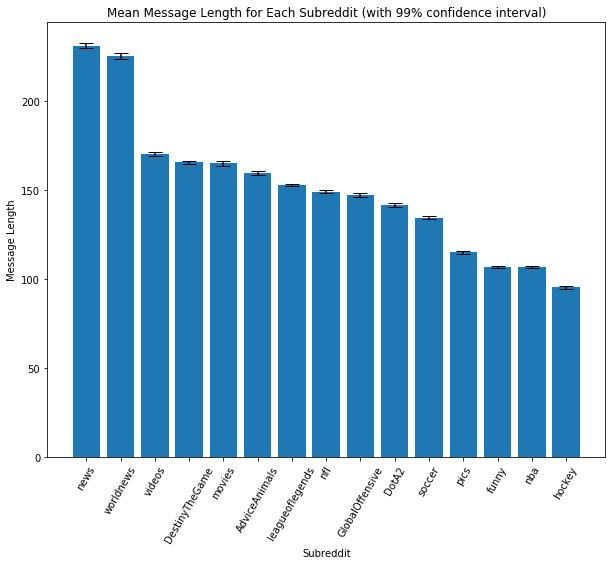

In [50]:
# compute the range of 99% confidence interval for the mean
pd_mean_message_length = (mean_message_length.sort(desc("mean_message_len"))).toPandas()
pd_se_message_length = (se_message_length.sort(desc("se_message_len"))).toPandas()
pd_message_length = pd_mean_message_length.merge(pd_se_message_length, on="subreddit")
n = len(pd_message_length)

# plot the mean of message length for each subreddit in descending order
plt.figure(figsize=(10, 8))
plt.bar(
    np.arange(n),
    pd_message_length.mean_message_len,
    yerr=3 * pd_message_length["se_message_len"],
    capsize=7,
)
plt.xticks(np.arange(n), pd_message_length.subreddit, rotation=60)
plt.xlabel("Subreddit")
plt.ylabel("Message Length")
plt.title("Mean Message Length for Each Subreddit (with 99% confidence interval)")
plt.show()

> #### ***Explanation***
- We plotted confidence interval **for the mean** of message length in each subreddit.
- We could see that the confidence intervals are pretty small since we have **large amount of data**: we can be quite confident that the computed mean is very close to the "real" one.

### B1.3. Identify the subreddit with the highest average score

Print the list of subreddits sorted by their average content scores.

In [51]:
posts_scores = posts.join(scores, "id")
avg_scores = (
    posts_scores.groupBy("subreddit")
    .agg(avg("score").alias("avg_score"))
    .sort(desc("avg_score"))
)
avg_scores.show()

+---------------+------------------+
|      subreddit|         avg_score|
+---------------+------------------+
|         videos|12.649445152612358|
|           pics|12.216559020162904|
|          funny|12.041505399058655|
|  AdviceAnimals|11.251695791717447|
|         soccer|10.634627593554693|
|         movies|  9.82014997137628|
|            nfl| 9.048348913155358|
|            nba| 9.032795071943161|
|           news| 8.673421150697779|
|      worldnews|  7.86683719564787|
|         hockey| 6.520120515039979|
|leagueoflegends| 5.983557531701479|
|          DotA2| 4.880537971129092|
|GlobalOffensive| 4.351442475073099|
| DestinyTheGame|3.0288819084811953|
+---------------+------------------+



## B2. Moderator assignment based on Subreddit Textual Content

Different subreddits follow different communication styles inherent in the topic and the community. Having said that, the goal is to discover similar subreddits by only looking at the *words* present in the posted messages. Once such a list of similar subreddits is identified, an appropriately chosen moderator can then be assigned to all these subreddits.

Specifically, the task boils down to computing a similarity score between two subreddits based on the *words* present in their textual content. Your first idea is to use the *Jaccard similarity*, which is defined as the size of the intersection of two sets divided by the size of their union.

$Jaccard(A,B) = \frac{|A \cap B|}{|A \cup B|}$

In [12]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

### B2.1.
The first step requires constructing a set representation of each subreddit. The goal is to represent each subreddit as a *set of words* existing in the messages posted on that subreddit. Compute the 50,000 most frequent words across all the provided subreddits. Construct a representation for each subreddit by retaining only the words found in the previously identified set of 50,000 frequent words.

Some rules:
 * Words are defined as tokens matching the regular expression `\W`
 * Remove all the stop-words (English language)

*Note: You might find the [RegexTokenizer](https://spark.apache.org/docs/2.2.0/ml-features.html#tokenizer) and the [StopWordsRemover](https://spark.apache.org/docs/2.2.0/ml-features.html#stopwordsremover) utilities available in the package pyspark.ml useful for this task as they help you in transforming the features and removing stopwords.*

In [55]:
# transform the body to the reagular expression
regexTokenizer = RegexTokenizer(inputCol="body", outputCol="words", pattern="\\W")
reddit_words = regexTokenizer.transform(posts)

# remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
reddit_words_filtered = remover.transform(reddit_words)

In [58]:
# the column 'filtered' shows that sentenses in the 'body' column are transformed to
# the regular expressions and stop words are removed from the sentenses.
reddit_words_filtered.select('body','words','filtered').show()

+--------------------+--------------------+--------------------+
|                body|               words|            filtered|
+--------------------+--------------------+--------------------+
|gg this one's ove...|[gg, this, one, s...|[gg, one, watch, ...|
|Nihilum and LG ar...|[nihilum, and, lg...|[nihilum, lg, sig...|
|Me too. Same hamm...|[me, too, same, h...|   [hammock, fabric]|
|well i think new ...|[well, i, think, ...|[well, think, new...|
|That's something ...|[that, s, somethi...|[something, hear,...|
|Because we aren't...|[because, we, are...|[aren, responsibl...|
|Well yeah. The fi...|[well, yeah, the,...|[well, yeah, firs...|
|**[STREAMLINK](ht...|[streamlink, http...|[streamlink, http...|
|1-She got to be a...|[1, she, got, to,...|[1, got, bigwig, ...|
|Holy shit, I coul...|[holy, shit, i, c...|[holy, shit, coul...|
|Do you get to jus...|[do, you, get, to...|[get, make, nickn...|
|https://i.imgur.c...|[https, i, imgur,...|[https, imgur, co...|
|But that isn't wh...|[bu

In [61]:
# compute the 50,000 most frequent words across all subreddits
# create a list of words used across all subreddits and sort them in descending order interms of frequency.
# 1. .rdd.flatMap: Convert the column, 'filtered', to rdd and extract words from word list in a row
# 2. .map: Create array, ('word', 1) to count a frequency or each word.
# 3. .reduceByKey: Count a frequency
# 4. .Sort the words in descending order by frequency
word_data = (
    reddit_words_filtered.rdd.flatMap(lambda row: (row.filtered))
    .map(lambda x: (x, 1))
    .reduceByKey(lambda x, y: x + y)
    .sortBy(lambda x: x[1], ascending=False)
)

In [26]:
# ensure that freqency of each words are calculated correctly and words are sorted in descending order
word_data.take(3)

[('like', 1018978), ('people', 745031), ('get', 691349)]

In [27]:
# extract words from the arrays ('word', frequency) and obtain the list of top 50,000 frequent words
frequent_wordlist = word_data.map(lambda x: x[0]).take(50000)

In [41]:
# store the word list in notebook
%store frequent_wordlist

Stored 'frequent_wordlist' (list)


In [30]:
# obtain all subreddit list in the given dataframe
subreddit_list = (
    reddit_words_filtered.select("subreddit")
    .distinct()
    .rdd.map(lambda row: (row.subreddit))
    .collect()
)

In [201]:
# store the subreddit list in this notebook
%store subreddit_list

Stored 'subreddit_list' (list)


In [166]:
# compute lists of words used in each subreddit. The lists contains words in the list of top 50,000 frequent words.
# 1. .where: Withdrow posts in a selected subreddit
# 2. .rdd.flatMap: Convert the column, 'filtered', to rdd and extract words from the word list in a row
# 3. .map: Create array ('word', 1)
# 4. .reduceByKey: Count the frequancy of each word to eliminate duplication
# 5. .map: Extract word from the array ('word', frequency)
# 6. .collect(): Create list of word used in a subreddit

subreddit_wordlist = []
for sr in subreddit_list:
    subreddit_words = reddit_words_filtered.where(reddit_words_filtered.subreddit == sr)
    temp = (
        subreddit_words.select("filtered")
        .rdd.flatMap(lambda row: (row.filtered))
        .map(lambda x: (x, 1))
        .reduceByKey(lambda x, y: x + y)
        .map(lambda x: x[0])
        .collect()
    )
    # obtain an intersection between the list of word used in each subreddit and 50,000 most frequent word
    temp_list = [value for value in temp if value in frequent_wordlist]
    # store the obtained list for a subreddit into a list
    subreddit_wordlist.append([sr, temp_list])

In [200]:
# store a list of word list used in each subreddit to this notebook
%store subreddit_wordlist

Stored 'subreddit_wordlist' (list)


### B2.2.
* Compute the Jaccard similarity between all the subreddits using the set representation obtained in step **B2.1.**, and plot in a heatmap the similarity values of all the pairs of subreddits.
* Analyze this plot and discuss your observations. Do you observe that subreddits corresponding to similar topics possess higher Jaccard similarity?
* Provide detailed interpretations of the obtained results. Specifically,
    - Explain the limitations of your conclusions, and discuss the potential reasons.
    - Explain the potential problems with the Jaccard similarity function.

In [63]:
# compute Jaccard similarity in terms of words used in each subreddit and in the list of top 50,000 frequent words. 
jsim_result = []
for list1 in subreddit_wordlist:
    sub_jsim_result = []
    for list2 in subreddit_wordlist:
        sub_jsim_result.append(jaccard_similarity(list1[1], list2[1]))
    jsim_result.append(sub_jsim_result)

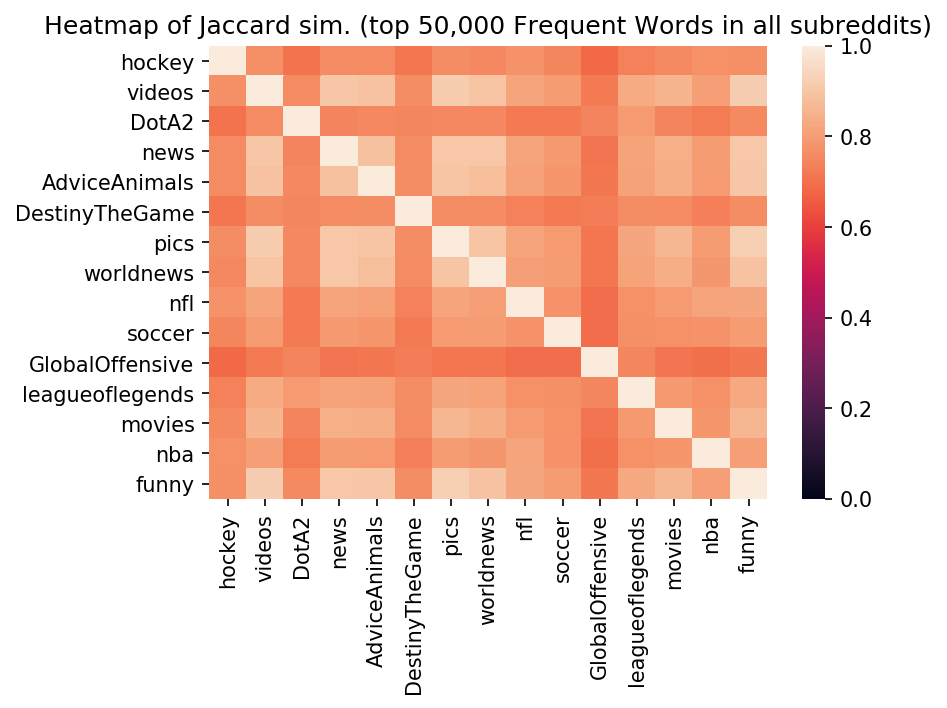

In [64]:
# plot a heatmap of calculated jaccard similarity for all the pairs of subreddits
plt.figure(figsize=(6, 4), dpi=150)
x_axis_labels = subreddit_list
y_axis_labels = subreddit_list
sns.heatmap(
    jsim_result,
    xticklabels=x_axis_labels,
    yticklabels=y_axis_labels,
    vmin=0.0,
    vmax=1.0,
)
plt.title("Heatmap of Jaccard sim. (top 50,000 Frequent Words in all subreddits)")
plt.show()

> #### ***Explanation***
>+ In general, we do not always observe high Jaccard Similarity between similar topics. We can explain this fact observing that words in natural language follow the **Zipf Law**, that means that there is a small group of words which occur with high propability and than there are words which are strongly topic-related and occur rarely. 
>
>   When we take 50 000 most used words from all comments, we create a group of words which consist mostly of **commonly used** words which are shared trough the subreddits (for exapmle: people, day, play, etc.). Anyway, words related to specific subreddits (LeBron (NBA player), Gretzky (ex-NHL player), Messi (soccer player), FaZe (CS:GO clan), Pudge (DotA2 hero), etc.) can be included in the list too: the occurencies of the 50 000-th word are 44, which, given the amount of the messages, means that also strictly **topic related** words are actually in the top 50 000.
>
>+ We could split the subreddits into two main categories: **General** and **Specific** ones.
>
>   Into the first category we can find two subgroups: **News** (*news* and *worldnews*) and **Free time** (*videos*, *AdviceAnimals*, *pics*, *movies*, *funny*) fall . They do not contains so many topic related words and are mostly composed of common daily used language. That is the reason why their crossed Jaccard similarities are quite high.
>
>   Specific channels can be divided into **Gaming** (*DatA2*, *DestinyTheGame*, *GlobalOffensive*, *leagueoflegends*) and **Sport** (*hockey*, *soccer*, *nfl*, *nba*). The low Jaccard Similarity inside those subgroups can be due to the fact that, among the 50 000 words, the great majority is of common use, many of them are strictly related to a single subreddit and only few of them can be seen as a link between different subreddits (e.g. *run* for the category Sport or *joystick* for the Gaming subreddits).
>
>+ **Limitations of Jaccard Similarity**: this metric takes into account only presence of the words, not their frequency, so it does not truly capture the distribution of the words in each of the subreddits. To improve the metric we could use a method which computes the similiarity in the same way but using multisets instead of sets.

### B2.3.

* Alternatively, compute the 1000 most frequent words for each subreddit, construct its representation as the set of top-1000 words, and print a heatmap with the Jaccard similarity like in step **B2.2.**.
* Explain your observations in detail: how and why is this new result different from the one obtained in **B2.2.**?

*Note: Use the same rules specified in B2.1: words tokenized with the regex \W and stop-words removed*

In [79]:
# compute lists of top 1,000 frequent words used in each subreddit.
# 1. .where: Withdrow posts in a selected subreddit
# 2. .rdd.flatMap: Convert the column, 'filtered', to rdd and extract words from the word list in a row
# 3. .map: Create array, ('word', 1) to count a frequency or each word.
# 4. .reduceByKey: Count a frequency
# 5. .sortBy: Sort the words in descending order by frequency
# 6. .map: Extract words from arrays ('word', frequency)
# 7. .take(1000): Obtain top 1,000 frequent word in the selected subreddit
subreddit_wordlist2 = []
for sr in subreddit_list:
    subreddit_word_data = (
        reddit_words_filtered.where(reddit_words_filtered.subreddit == sr)
        .select("filtered")
        .rdd.flatMap(lambda row: (row.filtered))
        .map(lambda x: (x, 1))
        .reduceByKey(lambda x, y: x + y)
        .sortBy(lambda x: x[1], ascending=False)
        .map(lambda x: x[0])
        .take(1000)
    )
    # Store the word lists into list
    subreddit_wordlist2.append([sr, subreddit_word_data])


In [202]:
%store subreddit_wordlist2

Stored 'subreddit_wordlist2' (list)


In [13]:
# compute Jaccard similarity in terms of top 1,000 frequent words used in each subreddit between all the subreddits. 
jsim_result2 = []
for list1 in subreddit_wordlist2:
    sub_jsim_result2 = []
    for list2 in subreddit_wordlist2:
        sub_jsim_result2.append(jaccard_similarity(list1[1], list2[1]))
    jsim_result2.append(sub_jsim_result2)


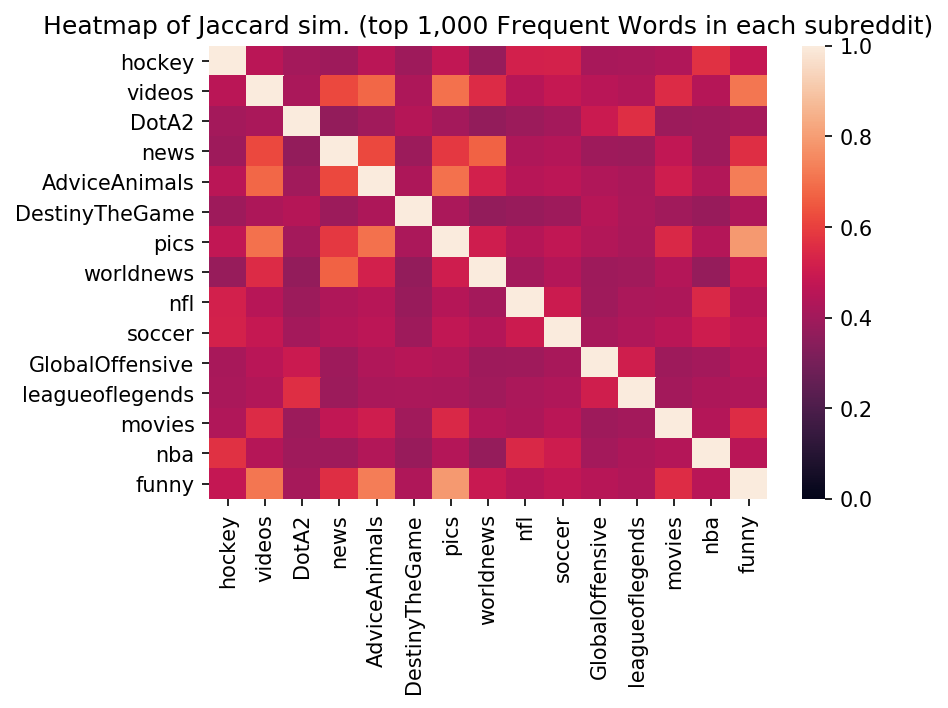

In [66]:
# plot a heatmap of calculated jaccard similarity for all the pairs of subreddits
plt.figure(figsize=(6, 4), dpi=150)
x_axis_labels = subreddit_list
y_axis_labels = subreddit_list
sns.heatmap(
    jsim_result2,
    xticklabels=x_axis_labels,
    yticklabels=y_axis_labels,
    vmin=0.0,
    vmax=1.0,
)
plt.title("Heatmap of Jaccard sim. (top 1,000 Frequent Words in each subreddit)")
plt.show()


> #### ***Explanation***
>+ On average the **similarities are lower**. This makes sense since we have selected 1,000 most frequent word in each of the subreddits separately, not in all channels combined.
>+ We can still identify a **similar pattern** to the one described with the top 50 000 words (General subreddits have higher similarities).
>+ The similarities inside the Specific groups (Sport and Gaming) are **more equalized** than before, accounting for the higher number of group-related words selected and their increased importance in the computation of similarity. For example, if a word like *joystick* is selected in all the Gaming subreddits now has about 50 times more importance than when selecting 50 000 words ranking them globally.

## B3. Moderator assignment based on Subreddit Users

Subreddits can be seen as communities of people interacting about a common topic. As an alternative to the *textual content* based similarity in **B2**, your task here is to validate if similarity between two subreddits can be measured based on their participating users.

Of course users are not monothematic, and they interact with multiple subreddits. In this task, we are specifically interested in observing the amount of overlap across different subreddits based on their participating users. Similar to **B2**, the overlap is measured using the *Jaccard similarity*.


### B3.1.
Construct a set representation of each subreddit as the users that posted at least one time in that subreddit.

Some users are very talkative and active across different topics. Print the username of the person that posted in the maximum number of subreddits. *Note that users who posted at least once in a subreddit are considered as participant of that subreddit.*

In [82]:
# post with no word (empty) is not considered as active posts
# we define active users in a subreddit as those who made at least one active post in the subreddit.
# create lists of active users in each subreddit.
# 1. .where(.isNotNull): Drop post with no word (empty) in order to pick up user who post at least once.
# 2. .where(.subreddit == ): Withdrow posts in a selected subreddit
# 3. .rdd.map: Convert the column, 'filtered', to rdd and extract words from the word list in a row
# 4. .map: Create array ('user', 1)
# 5. .reduceByKey: Count the frequancy of user to fined the most active user in the subreddit and eliminate duplication
# 6. .sortBy: Sort the users in descending order by frequency
# 7. .map: Extract users from arrays ('user', frequency)
# 8. .collect: Create list of users in the subreddit
subreddit_authorlist = []
for sr in subreddit_list:
    subreddit_author = (
        reddit_join.where(reddit_join.body.isNotNull())
        .where(reddit_join.subreddit == sr)
        .select("author")
        .rdd.map(lambda row: (row.author))
        .map(lambda x: (x, 1))
        .reduceByKey(lambda x, y: x + y)
        .sortBy(lambda x: x[1], ascending=False)
        .map(lambda x: x[0])
        .collect()
    )
    # Store the user list into list
    subreddit_authorlist.append([sr, subreddit_author])


In [203]:
%store subreddit_authorlist

Stored 'subreddit_authorlist' (list)


In [3]:
# username of the person that posted in the maximum number of subreddits.
sorted_user_activities = (
    posts.groupBy("author")
    .agg(countDistinct("subreddit").alias("distinctSubreddits"))
    .sort(desc("distinctSubreddits"))
)
sorted_user_activities.show(10)

+--------------------+------------------+
|              author|distinctSubreddits|
+--------------------+------------------+
|             whispen|                15|
|             PaidBot|                14|
|Really_Like_Pancakes|                13|
|       AutoModerator|                13|
|     TheSublimeLight|                12|
|            Galactic|                12|
|              Tashre|                12|
|        poopsmith666|                12|
|     naturelover7777|                12|
|   PitchforkEmporium|                12|
+--------------------+------------------+
only showing top 10 rows



### B3.2.

* Compute the Jaccard similarity between all the subreddits using the set representation obtained in step **B3.1.**, and visualise it similar to **B2**.
* Analyze this plot, identify highly similar pairs of subreddits, and clearly describe your observations.

In [14]:
# compute the Jaccard similarity in terms of active users in each subreddit between all the subreddits.
jsim_author = []
for list1 in subreddit_authorlist:
    sub_jsim_author = []
    for list2 in subreddit_authorlist:
        sub_jsim_author.append(jaccard_similarity(list1[1], list2[1]))
    jsim_author.append(sub_jsim_author)


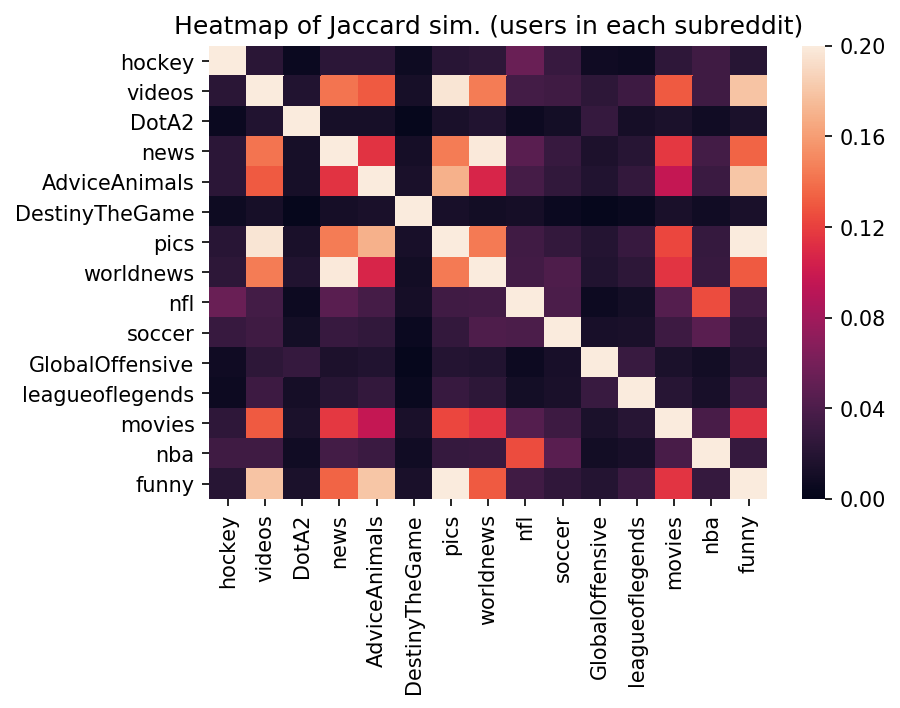

In [68]:
# plot a heatmap of calculated jaccard similarity for all the pairs of subreddits
plt.figure(figsize=(6, 4), dpi=150)
x_axis_labels = subreddit_list
y_axis_labels = subreddit_list
sns.heatmap(
    jsim_author,
    xticklabels=x_axis_labels,
    yticklabels=y_axis_labels,
    vmin=0.0,
    vmax=0.2,
)
plt.title("Heatmap of Jaccard sim. (users in each subreddit)")
plt.show()


> #### ***Explanation***
>+ Similarity is much lower than in the previous tasks, since natural language is ambigous and many words can be used with multiple different meanings, while **users rarely share different interests**. 
>+ Moreover, the dataset consists only of messages, so users' interests cannot be catched if they **only read a subreddit** but do not participate to the discussion.
>+ General subreddits still show the **highest similarity**.
>+ The Gaming group subreddits are the one that show the **lowest similarity**. Apparently, gamers only like to play at a single specific game.

## B4. Language vs. Users similarity
    
* Visualize the similarity scores based on word (**B2.3.**) and user (**B3**) similarity on the x and y axes respectively for the subreddit `NBA` compared to all the other subreddits. Do some semantically meaningful groups emerge? Provide clear explanataions of your observations.
* Furthermore, do you observe differences in similarities between various sports-related subreddits in the dataset? Please provide explanations of the reasons behind these differences, if any!

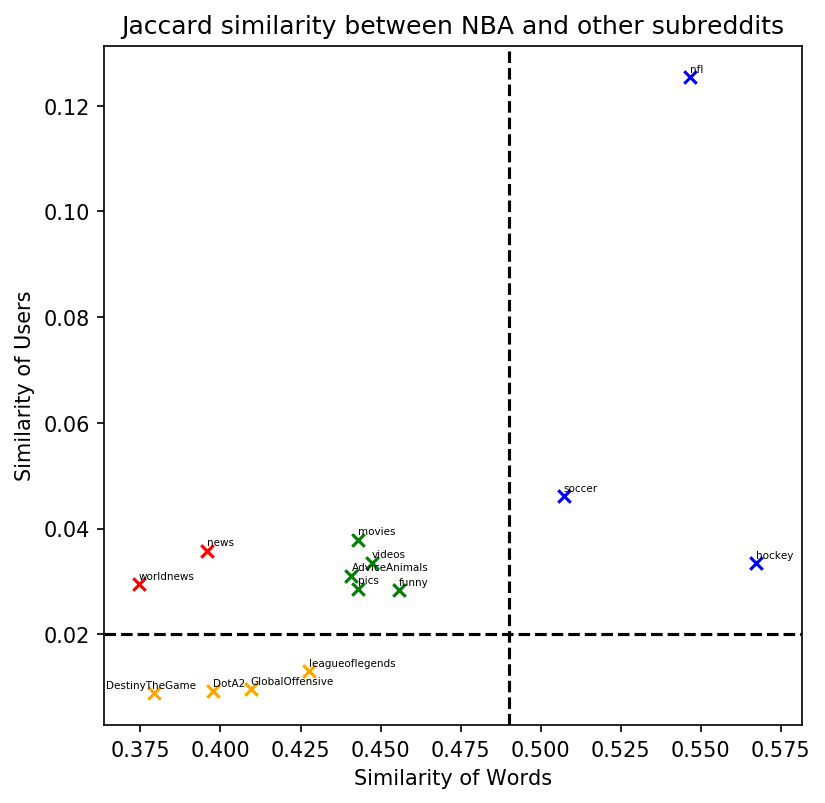

In [28]:
# create a plot to show jaccard similarities based on word(B2.3) and user(B3) between NBA and other subreddits
plt.figure(figsize=(6, 6), dpi=150)
for i, sr in enumerate(subreddit_list):
    if sr == "nba":
        continue
    x = jsim_result2[13][i]
    y = jsim_author[13][i]
    if sr in ['news', 'worldnews']:
            plt.scatter(x, y, marker="x", color="red")
    if sr in ['nfl', 'soccer', 'hockey']:
            plt.scatter(x, y, marker="x", color="blue")
    if sr in ['movies', 'videos','funny','pics','AdviceAnimals']:
            plt.scatter(x, y, marker="x", color="green")
    if sr in ['DotA2', 'DestinyTheGame','GlobalOffensive','leagueoflegends']:
            plt.scatter(x, y, marker="x", color="orange")
 
    if i == 5:
        plt.text(x - 0.015, y + 0.001, sr, fontsize=5)
    else:
        plt.text(x, y + 0.001, sr, fontsize=5)
plt.axvline(x=0.49, color="k", linestyle="--")
plt.axhline(y=0.02, color="k", linestyle="--")
plt.title("Jaccard similarity between NBA and other subreddits")
plt.xlabel("Similarity of Words")
plt.ylabel("Similarity of Users")
plt.show()


> #### ***Explanation***
>+ When we look at the plot above, we can clearly divide the subreddit into four groups by their relation to the nba.
> 
>   1. **Sport**: we can observe that NBA subreddit shares more than a half of the 1,000 most frequent with other sport related channels: *nfl*, *hockey* and *soccer*. From the user point of view, the correlation is much higher with *nfl*, which makes sense since both of these subreddits are related to the **sport leagues in the USA**. Hockey and soccer are **common sports** around the world, so people interested in these sports are not necessarily interested in USA basketball. 
> 
>   2. **Free time**: the general channels contain many of the **commonly used words**, which are also used in *nba* subreddit. These topics are not strongly content dependent and, as shown before, they can involve **every kind of user**.
> 
>   3. **News**: there are few shared words. This can be connected to the fact that language used in a news channel is **more formal**. The number of the shared users is low, but still higher than for Gaming subreddits, highlighting the fact that news is a **general interest** many people share.
> 
>   4. **Gaming**: the Gaming subreddits has the **lowest correlation** with *nba* from both points of view. As was shown before, the Gaming channels are **strongly topic related** and there is not a connection between the vocabularies of NBA and Gaming. When we look at the shared users ration, slightly above 0, which supports assumptions that the general gaming community does not have an interest in classical sports.

## Code Formatting Notes
The code was formatted by Black - The uncompromising Python code formatter. For further informations please click [here](https://github.com/psf/black "Black's GitHub").

All imports are sorted in alphabetical order.